### Installations

In order to work through this notebook, you must install pyulog and pandas.

+ Install pyulog:
~~~~
sudo apt-get install python-testresources
sudo pip install pyulog
~~~~

+ Install pandas:
~~~~
sudo apt-get install python-pandas
~~~~

### Recording a flight log
A new flight log is recorded every time the flight controller is powered on (and are stored when it powered off). To record a new flight log:

+ In QGroundControl, click on the "page and magnifying glass" symbol in the top left corner. Select **Mavlink Console**.
+ To start recording a new flight log, enter `reboot` into the command terminal.
+ To stop recording, enter`reboot` into the command terminal again.
+ Flight data is logged using the .ulog file format. 

<div class="alert alert-info">
**Note:** Optical flow must be started *after* the first reboot
</div>

### Accessing a flight log
You can access your flight logs (stored as .ulg files) in `/var/lib/mavlink-router/`

### Converting .ulg file to .csv file
In this nootbook we will work with a pandas dataframe. In order to create a pandas dataframe of flight log data, we must first convert the .ulg file to .csv files (one .ulg file will be split into multiple .csv files, each containing specific flight infomation). This can be done with the following command:
~~~~
ulog2csv <your-ulg-file>.ulg
~~~~

+ The unfiltered accelorometer data is stored in the 'sensor_combined' .csv file
+ The filtered accelorometer date is stored in the 'estimator_status' .csv file

In [1]:
import pandas as pd
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt



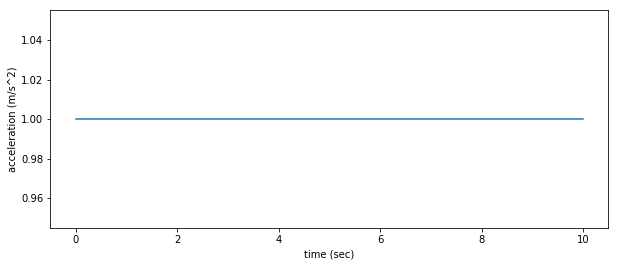

In [2]:
# Example acceleration data representing constant acceleration over a period of 10 seconds
data = [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)] # (time, accel)

times = []
accel = []
for point in data: 
    times.append(point[0])
    accel.append(point[1])
    
# Plot acceration vs. time
fig,ax = plt.subplots()
ax.plot([time for time in times], accel)
ax.set_ylabel('acceleration (m/s^2)')
ax.set_xlabel('time (sec)')
fig.set_size_inches(10,4)

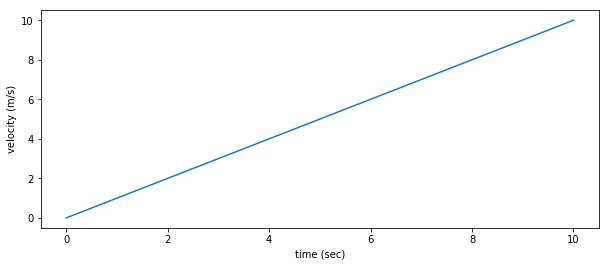

In [3]:
# Integrate acceration to get the drone's velocity at each time
vel = scipy.integrate.cumtrapz(accel, x = times, initial = 0)

# Plot velocity vs. time
fig,ax = plt.subplots()
ax.plot([time for time in times], vel)
ax.set_ylabel('velocity (m/s)')
ax.set_xlabel('time (sec)')
fig.set_size_inches(10,4)

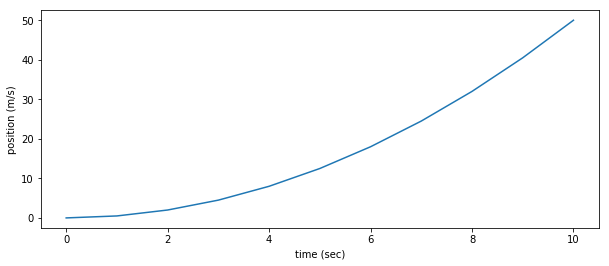

In [4]:
# Integrate velocity to get the drone's position at each time
pose = scipy.integrate.cumtrapz(vel, x = times, initial = 0)

# Plot position vs. time
fig,ax = plt.subplots()
ax.plot([time for time in times], pose)
ax.set_ylabel('position (m/s)')
ax.set_xlabel('time (sec)')
fig.set_size_inches(10,4)

### Load log data

The first data frame we will create contains the accelerations measured by the drone's accelerometer. The columns accelerometer_m_s2[0], accelerometer_m_s2[1], and accelerometer_m_s2[2] contain the accelerations measured in the XYZ body frame (in m/s/s).

In [5]:
# Load sensor data as a pandas data frame
sensor_data = pd.DataFrame.from_csv('example_flight_log_sensor_combined_0.csv')
sensor_data.head()

IOError: File example_flight_log_sensor_combined_0.csv does not exist

The second data frame we will create contains state estimation data that has been filtered by an algorithm called the Extended Kalman Filter (EKF). The EKF processes sensor measurements from multiple sources (IMU, magnitometer, range finder, optical flow, etc.) and blends them together to get a much more accurate estimation of the drone's state. The columns states[4], states[5], and states[6] contain the velocities in the NED frame (in m/s).

In [10]:
# Load EKF data as a pandas data frame
ekf_data = pd.DataFrame.from_csv('example_flight_log_estimator_status_0.csv')
ekf_data.head()

,states[0],states[1],states[2],states[3],states[4],states[5],states[6],states[7],states[8],states[9],...,beta_test_ratio,time_slip,gps_check_fail_flags,filter_fault_flags,innovation_check_flags,solution_status_flags,nan_flags,health_flags,timeout_flags,pre_flt_fail
timestamp,,,,,,,,,,,,,,,,,,,,,
9574551,0.844847,0.000967,0.002389,0.535003,0.000542,0.002735,-0.018987,0.000307,0.000988,-0.078965,...,0,0.000028,0,0,0,165,0,0,0,0
9775327,0.844838,0.000961,0.002416,0.535016,-0.000347,0.002749,-0.017892,0.000245,0.000989,-0.078547,...,0,0.000004,0,0,0,165,0,0,0,0
9980219,0.844891,0.000986,0.002464,0.534931,-0.001463,0.003186,-0.004340,0.000013,0.001052,-0.047573,...,0,0.000095,0,0,0,165,0,0,0,0
10180948,0.844995,0.001037,0.002431,0.534768,-0.001090,0.003106,-0.012899,-0.000185,0.001216,-0.073921,...,0,0.000025,0,0,0,165,0,0,0,0
10385730,0.845045,0.001046,0.002483,0.534688,-0.002064,0.002994,-0.006199,-0.000347,0.001211,-0.056821,...,0,0.000007,0,0,0,165,0,0,0,0


### Filter the accelerometer data

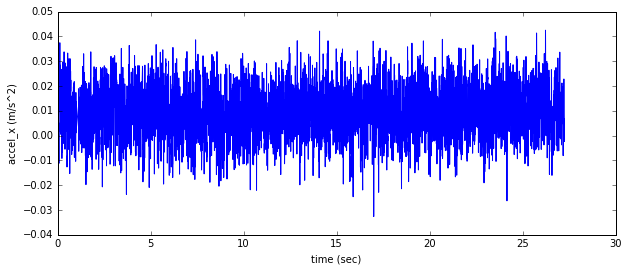

In [266]:
# Acceleration data in the XYZ body frame (m/s/s)
accel_x = sensor_data['accelerometer_m_s2[0]'].tolist()
accel_y = sensor_data['accelerometer_m_s2[1]'].tolist()
accel_z = sensor_data['accelerometer_m_s2[2]'].tolist()

def get_times(timestamps):
    """
    Given a list of timestamps (in microseconds), returns a list of times (in seconds) starting at t = 0.
    
        Args:
            - timestamps = list of timestamps (microseconds)
            
        Returns: list of times (seconds) 
    """
    start = timestamps[0]
    k = 1.0/1000000
    times = []
    for timestamp in timestamps:
        time = k * (timestamp - start)
        times.append(time)
    return times

# Convert timestamps into a list of times (in sec) starting at t = 0.
sensor_times = get_times(sensor_data.index.tolist())

# Plot acceleration vs. time (we will only plot acceleration in the x direction)
fig,ax = plt.subplots()
ax.plot([time for time in sensor_times], accel_x)
ax.set_ylabel('accel_x (m/s^2)')
ax.set_xlabel('time (sec)')
fig.set_size_inches(10,4)

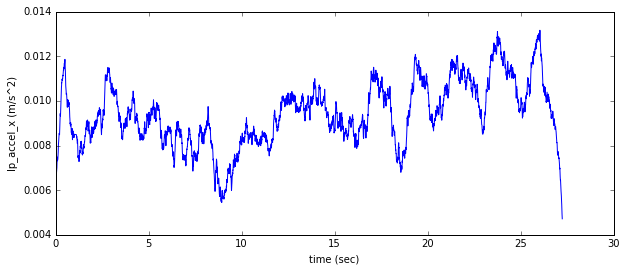

In [267]:
# Low pass filter example (not used)
def low_pass_filter(sequence, windowsize):
    positions = len(sequence) - windowsize + 1
    windows = []
    for i in range(positions):
        window = np.array(sequence[i:i+windowsize])
        mean = window.mean()
        windows.append(mean)
    return np.array(windows)

# Apply a low pass filter to the accelerometer data
windowsize = 200
lp_accel_x = np.convolve(accel_x, np.ones((windowsize,))/windowsize, mode='same')
lp_accel_y = np.convolve(accel_y, np.ones((windowsize,))/windowsize, mode='same')
lp_accel_z = np.convolve(accel_z, np.ones((windowsize,))/windowsize, mode='same')

# Plot lpf acceleration vs. time (we will only plot acceleration in the x direction)
fig,ax = plt.subplots()
ax.plot([time for time in sensor_times], lp_accel_x)
ax.set_ylabel('lp_accel_x (m/s^2)')
ax.set_xlabel('time (sec)')
fig.set_size_inches(10,4)

### Calculate change in position

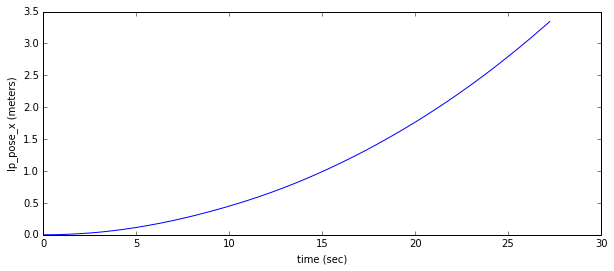

In [268]:
# Integrate acceration to get the drone's velocity at each time
lp_vel_x = scipy.integrate.cumtrapz(lp_accel_x, sensor_times, initial = 0)
lp_vel_y = scipy.integrate.cumtrapz(lp_accel_y, sensor_times, initial = 0)
lp_vel_z = scipy.integrate.cumtrapz(lp_accel_z, sensor_times, initial = 0)

# Integrate velocity to get the drone's position at each time
lp_pose_x = scipy.integrate.cumtrapz(lp_vel_x, sensor_times, initial = 0)
lp_pose_y = scipy.integrate.cumtrapz(lp_vel_y, sensor_times, initial = 0)
lp_pose_z = scipy.integrate.cumtrapz(lp_vel_z, sensor_times, initial = 0)

# Plot position vs. time (we will only plot acceleration in the x direction)
fig,ax = plt.subplots()
ax.plot([time for time in sensor_times], lp_pose_x)
ax.set_ylabel('lp_pose_x (meters)')
ax.set_xlabel('time (sec)')
fig.set_size_inches(10,4)

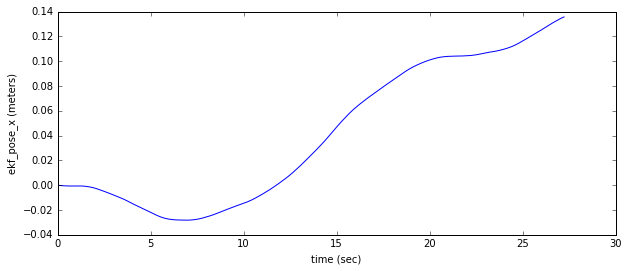

In [269]:
# EKF velocity data in the NED frame (m/s)
ekf_vel_x = ekf_data['states[4]'].tolist()
ekf_vel_y = ekf_data['states[5]'].tolist()
ekf_vel_z = ekf_data['states[6]'].tolist()

# Convert timestamps into a list of times (in sec) starting at t = 0.
ekf_times = get_times(ekf_data.index.tolist())

# Integrate EKF velocity to get the drone's position at each time
ekf_pose_x = scipy.integrate.cumtrapz(ekf_vel_x, ekf_times, initial = 0)
ekf_pose_y = scipy.integrate.cumtrapz(ekf_vel_y, ekf_times, initial = 0)
ekf_pose_z = scipy.integrate.cumtrapz(ekf_vel_z, ekf_times, initial = 0)

# Plot position vs. time (we will only plot acceleration in the x direction)
fig,ax = plt.subplots()
ax.plot([time for time in ekf_times], ekf_pose_x)
ax.set_ylabel('ekf_pose_x (meters)')
ax.set_xlabel('time (sec)')
fig.set_size_inches(10,4)

### Calculate the total change in position in the XY plane

In [270]:
# Translation vector calculated from the lpf accelerometer data (in XY plane)
lp_vector_xy = [lp_pose_x[-1], lp_pose_y[-1]]

# Translation vector calculated from the ekf velocity data (in XY plane)
ekf_vector_xy = [ekf_pose_x[-1], ekf_pose_y[-1]]

def magnitude(vector):
    """
    Given a vector, returns its magnitude (aka norm).
        
        Args:
            - vector: list (arbitrary length)
            
        Returns: ||vector||
    """
    if vector == []:
        return None
    total = 0
    for component in vector:
        total += component**2
    return total**0.5

print('lp: ' + str(lp_vector_xy) + ', magnitude = ' + str(magnitude(lp_vector_xy)))
print('efk: ' + str(ekf_vector_xy) + ', magnitude = ' + str(magnitude(ekf_vector_xy)))


lp: [3.3439469297526188, -16.924124750707787], magnitude = 17.2513182003
efk: [0.13572311271304097, 0.074065021640506018], magnitude = 0.154616916135
